In [284]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns


In [139]:
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files = True, split = ['train'])

In [140]:
def split(dataset, TRAIN_RATIO = 0.8, VAL_RATIO=0.1, TEST_RATIO=0.1):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
    
    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
    
    test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))
    
    return train_dataset, val_dataset, test_dataset

In [141]:
train_dataset, val_dataset, test_dataset = split(dataset[0])
print(list(train_dataset.take(1).as_numpy_iterator())
      , list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

### Visualization 

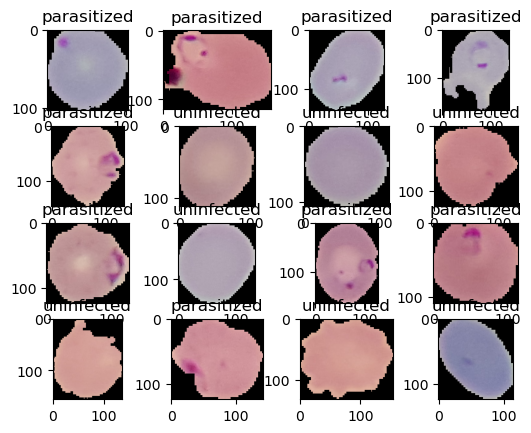

In [142]:
for i, (image,label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))

### Data Processing

In [143]:
IM_SIZE = 224
def resize_rescale(image,label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/ 255.0 , label

In [144]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [145]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [146]:
for image, label in train_dataset.take(1):
    print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [147]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration  = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration  = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [148]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Model Creation

### Sequential API

In [149]:
lenet_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    
                             Conv2D(filters =6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D(pool_size = 2, strides = 2),
    
                             Conv2D(filters =16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'sigmoid'),
                             BatchNormalization(),                        
                             MaxPool2D(pool_size = 2, strides = 2),
    
                             Flatten(),
    
                             Dense(100, activation = "relu"),
                             BatchNormalization(),
    
                             Dense(10, activation = "relu"),
                             BatchNormalization(),
    
                             Dense(1, activation = "sigmoid"),   

])

lenet_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_71 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_127 (B  (None, 222, 222, 6)       24        
 atchNormalization)                                              
                                                                 
 max_pooling2d_71 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_72 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_128 (B  (None, 109, 109, 16)      64        
 atchNormalization)                                              
                                                     

### Functional API

In [150]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters =6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)

x = Conv2D(filters =16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output =  MaxPool2D(pool_size = 2, strides = 2)(x)

feature_extractor_model = Model(func_input, output, name = "feature_extractor")
feature_extractor_model.summary()
                                        
                            

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_73 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_131 (B  (None, 222, 222, 6)       24        
 atchNormalization)                                              
                                                                 
 max_pooling2d_73 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_74 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_132 (B  (None, 109, 109, 16)

In [151]:
IM_SIZE - 224
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    
    
    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),                        
    MaxPool2D(pool_size = 2, strides = 2),
    
    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
])

feature_extractor_seq_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_133 (B  (None, 222, 222, 6)       24        
 atchNormalization)                                              
                                                                 
 max_pooling2d_75 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_76 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_134 (B  (None, 109, 109, 16)      64        
 atchNormalization)                                              
                                                     

In [152]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")
# x = feature_extractor_model(func_input)
x  = feature_extractor_seq_model(func_input)
x =  Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

output =  Dense(1, activation = "sigmoid")(x)

lenet_model = Model(func_input, output, name = "lenet_model")

lenet_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_25 (Sequential)  (None, 54, 54, 16)        1136      
                                                                 
 flatten_33 (Flatten)        (None, 46656)             0         
                                                                 
 dense_45 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_135 (B  (None, 100)               400       
 atchNormalization)                                              
                                                                 
 dense_46 (Dense)            (None, 10)                1010      
                                                       

## Model Subclassing

In [153]:
class FeatureExtractor(Layer):
    def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
        super(FeatureExtractor, self).__init__()
        
        self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPool2D (pool_size = pool_size, strides = 2 * strides)
        
        self.conv_2 = Conv2D(filters = filters * 2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPool2D (pool_size = pool_size, strides = 2 * strides)
        
    def call(self, x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)
        
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)
        
        return x
    
feature_sub_classed = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)

In [154]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")
# x = feature_extractor_model(func_input)
x  = feature_sub_classed(func_input)
x =  Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

output =  Dense(1, activation = "sigmoid")(x)

lenet_model = Model(func_input, output, name = "lenet_model")

lenet_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor_6 (Featu  (None, 54, 54, 16)        1488      
 reExtractor)                                                    
                                                                 
 flatten_34 (Flatten)        (None, 46656)             0         
                                                                 
 dense_48 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_139 (B  (None, 100)               400       
 atchNormalization)                                              
                                                                 
 dense_49 (Dense)            (None, 10)                

## Model Class

In [155]:
class LenetModel(Model):
    def __init__(self):
        super(LenetModel, self).__init__()
        
        self.feature_extractor = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)
        
        self.flatten = Flatten()
        
        self.dense_1 = Dense(100, activation = "relu")
        self.batch_1 = BatchNormalization()
        
        self.dense_2 = Dense(1, activation = "sigmoid")
        self.batch_2 = BatchNormalization()
        
        self.dense_3 = Dense(1, activation = "sigmoid")
        
    def call(self, x, training):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)
        x = self.dense_2(x)
        x = self.batch_2(x)
        x = self.dense_3(x)

        
        return x
    
lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1,224,224,3]))

lenet_sub_classed.summary()




Model: "lenet_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_7 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_35 (Flatten)        multiple                  0         
                                                                 
 dense_51 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_143 (B  multiple                  400       
 atchNormalization)                                              
                                                                 
 dense_52 (Dense)            multiple                  101       
                                                                 
 batch_normalization_144 (B  multiple                

## Custom dense layer

In [210]:
class CustomDenseLayer(Layer):
    def __init__(self, output_units, activation):
        super(CustomDenseLayer, self).__init__()
        self.output_units = output_units
        self.activation = activation
        
    def build(self, input_feature_shape):
        self.w = self.add_weight(shape = (input_feature_shape[-1], self.output_units), initializer = "random_normal", trainable = True)
        self.b = self.add_weight(shape = (self.output_units,), initializer = "random_normal", trainable = True)
        
    def call(self, input_features):
            
        pre_output = tf.matmul(input_features, self.w) + self.b
            
            
        if self.activation == "relu":
            return tf.nn.relu(pre_output)
            
        elif self.activation == "sigmoid":
            return tf.math.sigmoid(pre_output)
            
        else:
            return pre_output

In [211]:
IM_SIZE = 224
lenet_custom_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    
                             Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D(pool_size = 2, strides = 2),
    
                             Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
                             BatchNormalization(),                        
                             MaxPool2D(pool_size = 2, strides = 2),
    
                             Flatten(),
    
                             CustomDenseLayer(10, activation = "relu"),
                             BatchNormalization(),
    
                             CustomDenseLayer(10, activation = "relu"),
                             BatchNormalization(),
    
                             CustomDenseLayer(1, activation = "sigmoid"),   

])

lenet_custom_model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_113 (Conv2D)         (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_209 (B  (None, 222, 222, 6)       24        
 atchNormalization)                                              
                                                                 
 max_pooling2d_113 (MaxPool  (None, 111, 111, 6)       0         
 ing2D)                                                          
                                                                 
 conv2d_114 (Conv2D)         (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_210 (B  (None, 109, 109, 16)      64        
 atchNormalization)                                              
                                                     

### Callbacks

In [261]:
class LossCallback(Callback):
    def on_epoch_end(self,epoch, logs):
        print("\n For Epoch Number {} the model has a loss of {}".format(epoch+1, logs["loss"]))
        
    def on_batch_end(self, batch, logs):
        print("\n For Batch Number {} the model has a loss of {}".format(batch + 1, logs))

In [266]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=True
)

In [273]:
es_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

In [282]:
def scheduler(epoch, lr):
  if epoch < 2:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

In [285]:
check_point = ModelCheckpoint(
    'checkpoints/',
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq='epoch',
)

### Model Training

In [274]:
metrics = [ TruePositives(name = 'tp'), FalsePositives(name = 'fp'), TrueNegatives(name = 'tn'), FalseNegatives(name = 'fn'), 
          BinaryAccuracy(name = 'accuracy'), Precision(name = 'precision'), Recall(name = 'recall'), AUC(name = 'auc') ]

In [275]:
lenet_custom_model.compile(optimizer = Adam(learning_rate = 0.01),
             loss = BinaryCrossentropy(),
             metrics = metrics
             )
                #metrics = RootMeanSquaredError()

In [286]:
history = lenet_custom_model.fit(train_dataset, validation_data = val_dataset,  epochs = 8, verbose = 1, callbacks=[csv_callback,es_callback, scheduler_callback, check_point])


Epoch 1: LearningRateScheduler setting learning rate to 0.007408182602375746.
Epoch 1/8
689/689 [==============================] - ETA: 0s - loss: 0.0108 - tp: 10989.0000 - fp: 38.0000 - tn: 10983.0000 - fn: 36.0000 - accuracy: 0.9966 - precision: 0.9966 - recall: 0.9967 - auc: 0.9997

AttributeError: 'NoneType' object has no attribute 'replace'

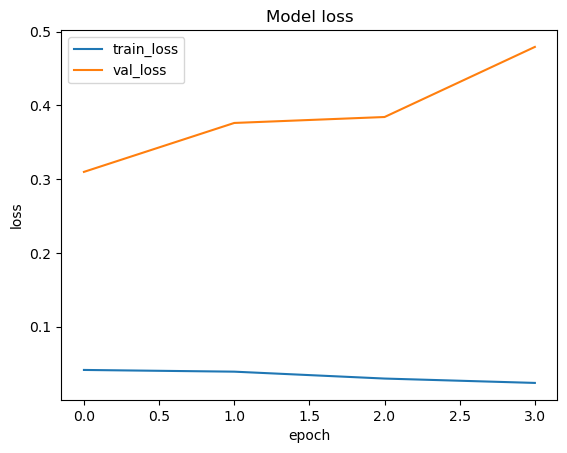

In [277]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

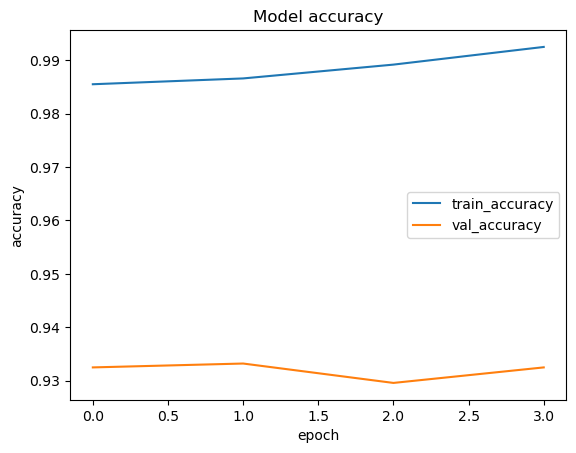

In [278]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

### Model Evaluation and Testing

In [218]:
test_dataset = test_dataset.batch(1)

In [219]:
lenet_custom_model.evaluate(test_dataset)

2757/2757 [==============================] - 8s 2ms/step - loss: 0.4468 - tp: 1345.0000 - fp: 291.0000 - tn: 1104.0000 - fn: 17.0000 - accuracy: 0.8883 - precision: 0.8221 - recall: 0.9875 - auc: 0.9492


[0.44678226113319397,
 1345.0,
 291.0,
 1104.0,
 17.0,
 0.8882843852043152,
 0.8221271634101868,
 0.9875183701515198,
 0.9492313265800476]

In [222]:
def parasite_or_not(x):
    if(x < 0.5):
        return str('P')
    else:
        return str('U')

In [223]:
parasite_or_not(lenet_model.predict(test_dataset.take(1)))

1/1 [==============================] - 1s 1s/step


'P'

1/1 [==============================] - 0s 9ms/step


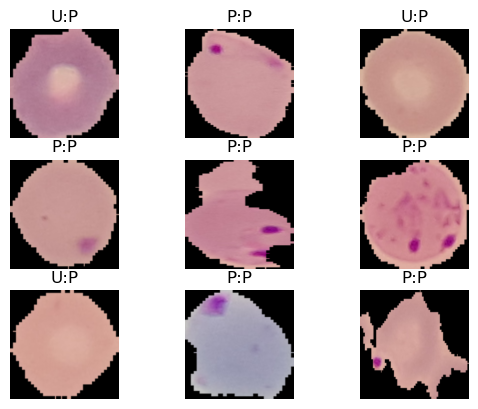

In [224]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[0])
    
    plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image)[0][0])))
    
    plt.axis('off')

Visualizing Confusion Matrix

In [235]:
labels = []

inp = []

for x,y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

In [238]:
print(np.array(inp).shape)
print(np.array(inp)[:,0,...].shape)

(2757, 1, 224, 224, 3)
(2757, 224, 224, 3)


In [233]:
# print(labels)
labels = np.array([i[0] for i in labels])


In [234]:
print(labels)

[1 1 0 ... 0 1 1]


In [240]:
predicted = lenet_custom_model.predict(np.array(inp)[:,0,...])
print(predicted[:,0])

87/87 [==============================] - 3s 27ms/step
[0.997726   0.00350764 0.99771506 ... 0.994579   0.98072207 0.99475837]


[[1103  289]
 [  17 1348]]


Text(0.5, 58.7222222222222, 'Predicted')

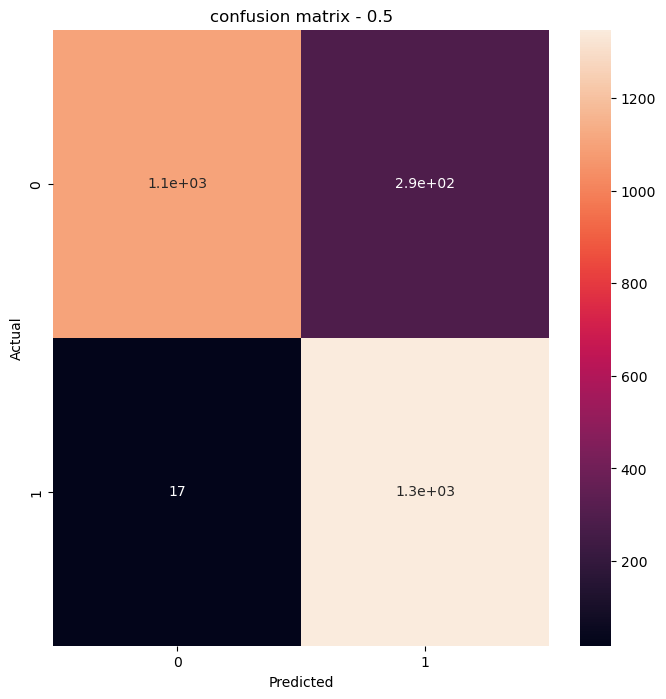

In [245]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)

print(cm)

plt.figure(figsize = (8,8))

sns.heatmap(cm, annot = True,)

plt.title('confusion matrix - {}'.format(threshold))

plt.ylabel('Actual')
plt.xlabel('Predicted')

ROC PLOT

422 422 422


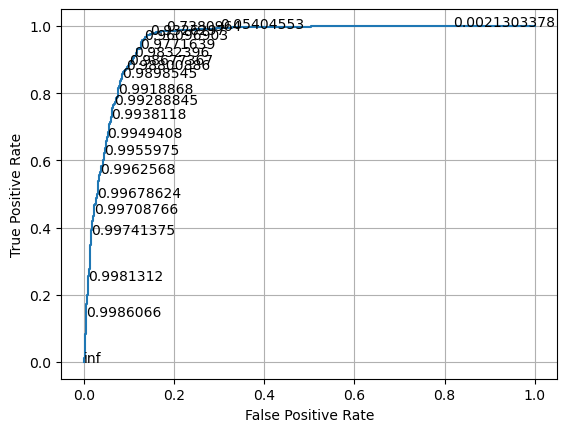

In [249]:
fp, tp, threshold = roc_curve(labels, predicted)
print(len(fp), len(tp), len(threshold))

plt.plot(fp,tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.grid()

skip = 20

for i in range(0, len(threshold), skip):
    plt.text(fp[i],tp[i], threshold[i])

plt.show()

### Functional API

### Resnet Model